Next Word prediction


App:-https://mlassignment3-paeadhh9pcaxwjeyvxcyrp.streamlit.app/

In [1]:
import re

filepath = '/content/paul_graham_essays.txt'


with open(filepath, 'r') as file:
    essay_text = file.read()


essay_text = re.sub(r'\.+', ' . ', essay_text)
essay_text = re.sub(r'\d+', '', essay_text)
essay_text = re.sub('[^a-zA-Z \.]', '', essay_text)
essay_text = essay_text.lower()

# Split the text into words
words = essay_text.split()

# Create a vocabulary of unique words (without the period '.')
unique_words = sorted(set(words) - {'.'})  # Remove period from the set of words

# Map words to integers (String to Integer mapping)
stoi = {w: i + 1 for i, w in enumerate(unique_words)}  # Start from 1 for words

# Assign the full stop ('.') to 0 as an end token
stoi['.'] = 0

# Reverse mapping: Integer to String
itos = {i: w for w, i in stoi.items()}

itos[0] = '.'

print("String to Integer mapping (stoi):", list(stoi.items())[:10])
print("Integer to String mapping (itos):", list(itos.items())[:10])


String to Integer mapping (stoi): [('a', 1), ('aa', 2), ('aaai', 3), ('aaron', 4), ('abandon', 5), ('abandoned', 6), ('abandoning', 7), ('abandons', 8), ('abase', 9), ('abbreviation', 10)]
Integer to String mapping (itos): [(1, 'a'), (2, 'aa'), (3, 'aaai'), (4, 'aaron'), (5, 'abandon'), (6, 'abandoned'), (7, 'abandoning'), (8, 'abandons'), (9, 'abase'), (10, 'abbreviation')]


In [2]:
print(stoi)

{'a': 1, 'aa': 2, 'aaai': 3, 'aaron': 4, 'abandon': 5, 'abandoned': 6, 'abandoning': 7, 'abandons': 8, 'abase': 9, 'abbreviation': 10, 'abby': 11, 'abc': 12, 'abducted': 13, 'abelson': 14, 'aberman': 15, 'aberration': 16, 'abilities': 17, 'abilitiesupwindi': 18, 'ability': 19, 'abjectly': 20, 'able': 21, 'abnb': 22, 'abnormal': 23, 'abnormally': 24, 'aboard': 25, 'abolition': 26, 'abolitionists': 27, 'abominably': 28, 'abortion': 29, 'about': 30, 'aboutthat': 31, 'aboutthose': 32, 'above': 33, 'aboveit': 34, 'abqa': 35, 'abroad': 36, 'abrupt': 37, 'absence': 38, 'absent': 39, 'absentminded': 40, 'absolute': 41, 'absolutely': 42, 'absorb': 43, 'absorbed': 44, 'abstemious': 45, 'abstinence': 46, 'abstract': 47, 'abstraction': 48, 'abstractions': 49, 'abstractness': 50, 'abstractsounding': 51, 'abstruse': 52, 'absurd': 53, 'absurdum': 54, 'abuse': 55, 'abused': 56, 'abuses': 57, 'abusing': 58, 'abusive': 59, 'academia': 60, 'academic': 61, 'academically': 62, 'academics': 63, 'acc': 64, '

In [3]:
print(len(words))
len(unique_words)

558627


17570

In [ ]:
import torch.nn as nn

#With activation tanh

class NextWordMLP(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)  # Convert word indices to embeddings
        x = x.view(x.shape[0], -1)  # Flatten embeddings
        x = torch.tanh(self.lin1(x))  # First layer + tanh activation
        x = self.lin2(x)  # Second layer, output vocab_size logits
        return x


In [ ]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True


In [ ]:
import torch
import pickle
hidden_size = 128
batch_size=1024

def save_model_and_vocab(model, model_filename, vocab_filename, stoi, itos):
    torch.save(model.state_dict(), model_filename)

    # Save the vocab mappings
    vocab_mappings = {'stoi': stoi, 'itos': itos}
    with open(vocab_filename, 'wb') as vocab_file:
        pickle.dump(vocab_mappings, vocab_file)


embedding_size = [128]
context_length = [5,10]
ectuple = [(e, c) for e in embedding_size for c in context_length]
i = 0





for t in ectuple:

    block_size = t[1]  # Context length for next-word prediction
    X, Y = [], []

    for i in range(len(words) - block_size):
        context = words[i:i+block_size]  # Select the context of `block_size` words
        next_word = words[i+block_size]  # The next word is the target to predict
        X.append([stoi[w] for w in context])  # Convert words to integers using stoi
        Y.append(stoi[next_word])  # Target word

    # Convert to PyTorch tensors and move to device
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    # X.shape, Y.shape


    # print(stoi[:6])
    x_train=X[:100000]
    y_train=Y[:100000]
    x_test=X[100000:150000]
    y_test=Y[100000:150000]
    print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

    model = NextWordMLP(t[1],len(stoi), t[0], hidden_size)
    model = torch.compile(model)
    loss_fn = nn.CrossEntropyLoss()
    opt = torch.optim.AdamW(model.parameters(), lr=0.001)

# Mini-batch training
# batch_size = 1024
    for epoch in range(100):
        c=0
        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            # print(x_batch.shape,y_batch.shape)
            c+=1
            # print(x_batch.shape)
            # Debugging: Check unique values in y_batch
            if torch.any(y_batch >= len(stoi)) or torch.any(y_batch < 0):
                print("Invalid indices found in y_batch:", y_batch[y_batch >= len(stoi)], y_batch[y_batch < 0])
                # Optionally, filter out invalid indices
                valid_indices = (y_batch < len(stoi)) & (y_batch >= 0)
                y_batch = y_batch[valid_indices]
                x_batch = x_batch[valid_indices]

            # Ensure x_batch and y_batch are of equal length after filtering
            if len(x_batch) == 0 or len(y_batch) == 0:
                continue  # Skip this batch if no valid samples

            # Forward pass
            y_pred = model(x_batch)

            # Compute loss
            loss = loss_fn(y_pred, y_batch)

            # Backward pass and optimization
            loss.backward()
            opt.step()
            opt.zero_grad()

        # Print loss every 10 epochs
        print(c)
        if epoch % 10 == 0:
          # print(c)
          print(f"Epoch {epoch}, Loss: {loss.item()}")

    model_filename = f"./model_{i}_e{t[0]}_c{t[1]}_Tanh.pt"
    vocab_filename = f"./vocab_{i}_e{t[0]}_c{t[1]}_Tanh.pkl"


    # Save model and vocab mappings
    save_model_and_vocab(model, model_filename, vocab_filename, stoi, itos)
    print(f"./model_e{t[0]}_c{t[1]}_tanh saved with embedding size {t[0]}, context length {t[1]}")
    print(f"./vocab_e{t[0]}_c{t[1]}_tanh saved with embedding size {t[0]}, context length {t[1]}")
    i += 1


torch.Size([100000, 5]) torch.Size([100000]) torch.Size([50000, 5]) torch.Size([50000])
98
Epoch 0, Loss: 6.67306661605835
98
98
98
98
98
98
98
98
98
98
Epoch 10, Loss: 4.295657157897949
98
98
98
98
98
98
98
98
98
98
Epoch 20, Loss: 3.090670347213745
98
98
98
98
98
98
98
98
98
98
Epoch 30, Loss: 2.3562183380126953
98
98
98
98
98
98
98
98
98
98
Epoch 40, Loss: 1.9450929164886475
98
98
98
98
98
98
98
98
98
98
Epoch 50, Loss: 1.7069623470306396
98
98
98
98
98
98
98
98
98
98
Epoch 60, Loss: 1.55557119846344
98
98
98
98
98
98
98
98
98
98
Epoch 70, Loss: 1.4543863534927368
98
98
98
98
98
98
98
98
98
98
Epoch 80, Loss: 1.3862695693969727
98
98
98
98
98
98
98
98
98
98
Epoch 90, Loss: 1.3362699747085571
98
98
98
98
98
98
98
98
98
./model_e128_c5_tanh saved with embedding size 128, context length 5
./vocab_e128_c5_tanh saved with embedding size 128, context length 5
torch.Size([100000, 10]) torch.Size([100000]) torch.Size([50000, 10]) torch.Size([50000])
98
Epoch 0, Loss: 6.543142318725586
98
98

T-SNE for clusters of words

<ipython-input-20-898840466476>:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/content/model_e128_c5_Tanh.pt", map_location=device)


Words in vocabulary: ['happy', 'sad', 'angry', 'excited', 'bored', 'anxious', 'relaxed', 'frustrated', 'surprised', 'content', 'disappointed', 'hopeful', 'nervous', 'cheerful', 'gloomy', 'embarrassed', 'curious', 'grateful', 'confident', 'lonely', 'satisfied', 'overwhelmed', 'optimistic', 'run', 'walk', 'jump', 'swim', 'fly', 'sit', 'dance', 'crawl', 'throw', 'catch', 'kick', 'lift', 'push', 'pull', 'climb', 'sprint', 'skip', 'slide', 'bounce', 'shout', 'dive', 'build', 'create', 'explore', 'quick', 'slow', 'beautiful', 'ugly', 'bright', 'dark', 'tall', 'short', 'hot', 'cold', 'heavy', 'light', 'soft', 'hard', 'loud', 'quiet', 'colorful', 'plain', 'rough', 'smooth', 'sweet', 'bitter', 'sour', 'sharp', 'blunt', 'delicate', 'mountain', 'river', 'banana', 'apple', 'dog', 'cat', 'car', 'city', 'ocean', 'book', 'computer', 'tree', 'house', 'flower', 'chair', 'table', 'phone', 'bicycle', 'sun', 'moon', 'star', 'planet', 'cloud', 'sky']


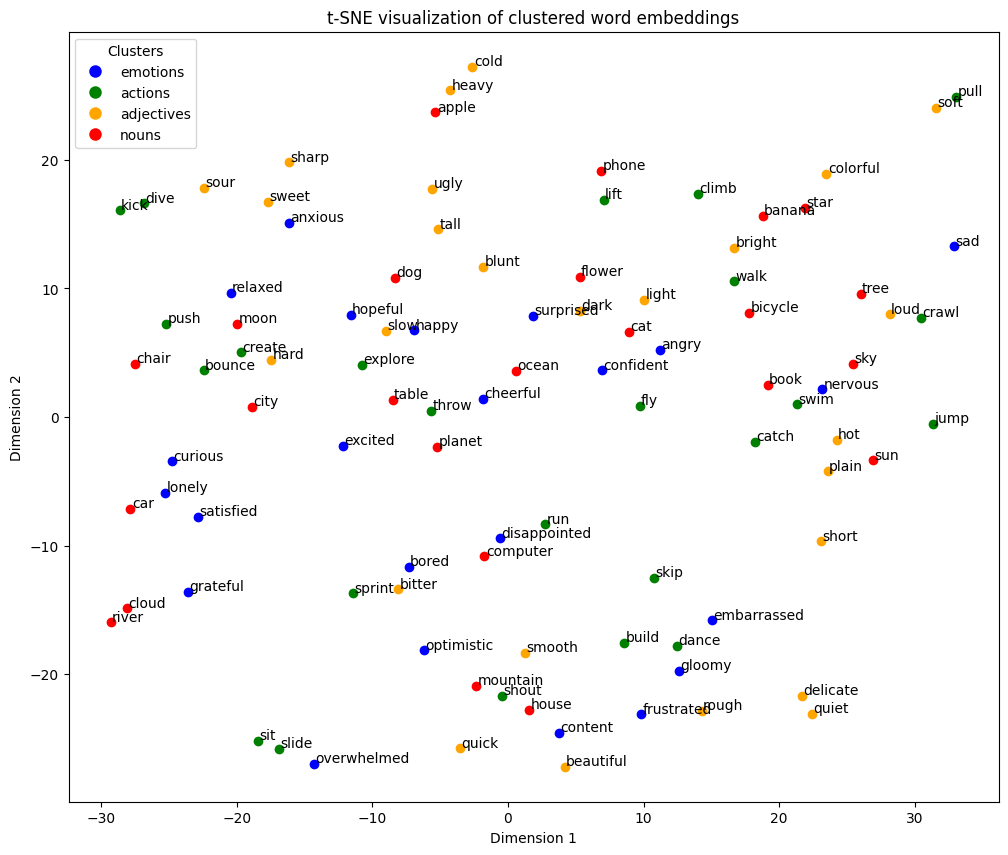

In [ ]:
import pickle as pkl
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def load_vocab(vocab_path):
    with open(vocab_path, 'rb') as f:
        vocab = pkl.load(f)
    return vocab


vocab=stoi
vocab_size = len(vocab)


class NextWordPredictor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, block_size):
        super(NextWordPredictor, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim * block_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, vocab_size)
        self.block_size = block_size

    def forward(self, x):
        x = self.embedding(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        out = self.fc2(x)
        return out

embedding_dim = 64
hidden_dim = 1024
block_size = 3
model = NextWordPredictor(vocab_size, embedding_dim, hidden_dim, block_size).to(device)
state_dict = torch.load("/content/model_e128_c5_Tanh.pt", map_location=device)
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace("_orig_mod.", "")  # Remove the '_orig_mod.' prefix
    new_state_dict[name] = v


model.load_state_dict(new_state_dict, strict=False)
model.eval()

clusters = {
    "emotions": [
        "happy", "joyful", "sad", "angry", "excited", "bored",
        "anxious", "relaxed", "frustrated", "surprised", "content",
        "disappointed", "hopeful", "nervous", "cheerful", "gloomy",
        "embarrassed", "curious", "grateful", "fearful", "confident",
        "lonely", "satisfied", "irritated", "overwhelmed", "optimistic"
    ],
    "actions": [
        "run", "walk", "jump", "swim", "fly", "sit",
        "dance", "crawl", "throw", "catch", "kick",
        "lift", "push", "pull", "climb", "sprint",
        "skip", "slide", "jog", "bounce", "shout",
        "whisper", "dive", "build", "create", "explore"
    ],
    "adjectives": [
        "quick", "slow", "beautiful", "ugly", "bright", "dark",
        "tall", "short", "hot", "cold", "heavy",
        "light", "soft", "hard", "loud", "quiet",
        "colorful", "plain", "rough", "smooth", "sweet",
        "bitter", "sour", "sharp", "blunt", "delicate"
    ],
    "nouns": [
        "Alice", "Bob", "mountain", "river", "banana", "apple",
        "dog", "cat", "car", "city", "ocean",
        "book", "computer", "tree", "house", "flower",
        "chair", "table", "phone", "bicycle", "sun",
        "moon", "star", "planet", "cloud", "sky"
    ],
}


# Flatten the list of clusters for visualization
selected_words = [word for group in clusters.values() for word in group]

# Check which words are in the vocabulary
words_in_vocab = [word for word in selected_words if word in vocab]
print(f"Words in vocabulary: {words_in_vocab}")

# Retrieve indices for words that are in the vocabulary
word_indices = [vocab[word] for word in words_in_vocab]

# Extract the embeddings for the selected words
with torch.no_grad():
    word_embeddings = model.embedding(torch.tensor(word_indices)).numpy()

# Use t-SNE to reduce embeddings to 2D space
tsne = TSNE(n_components=2, random_state=0, perplexity=5)
word_embeddings_2d = tsne.fit_transform(word_embeddings)


colors = {
    "emotions": "blue",
    "actions": "green",
    "adjectives": "orange",
    "nouns": "red"
}

# Plot the embeddings
plt.figure(figsize=(12, 10))
for i, word in enumerate(words_in_vocab):
    # Find the cluster for the current word
    for cluster_name, words in clusters.items():
        if word in words:
            plt.scatter(word_embeddings_2d[i, 0], word_embeddings_2d[i, 1], color=colors[cluster_name], label=cluster_name)
            plt.text(word_embeddings_2d[i, 0] + 0.1, word_embeddings_2d[i, 1] + 0.1, word, fontsize=10)
            break

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors.values()]
plt.legend(handles, colors.keys(), title="Clusters")

plt.title("t-SNE visualization of clustered word embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


T-SNE for random words

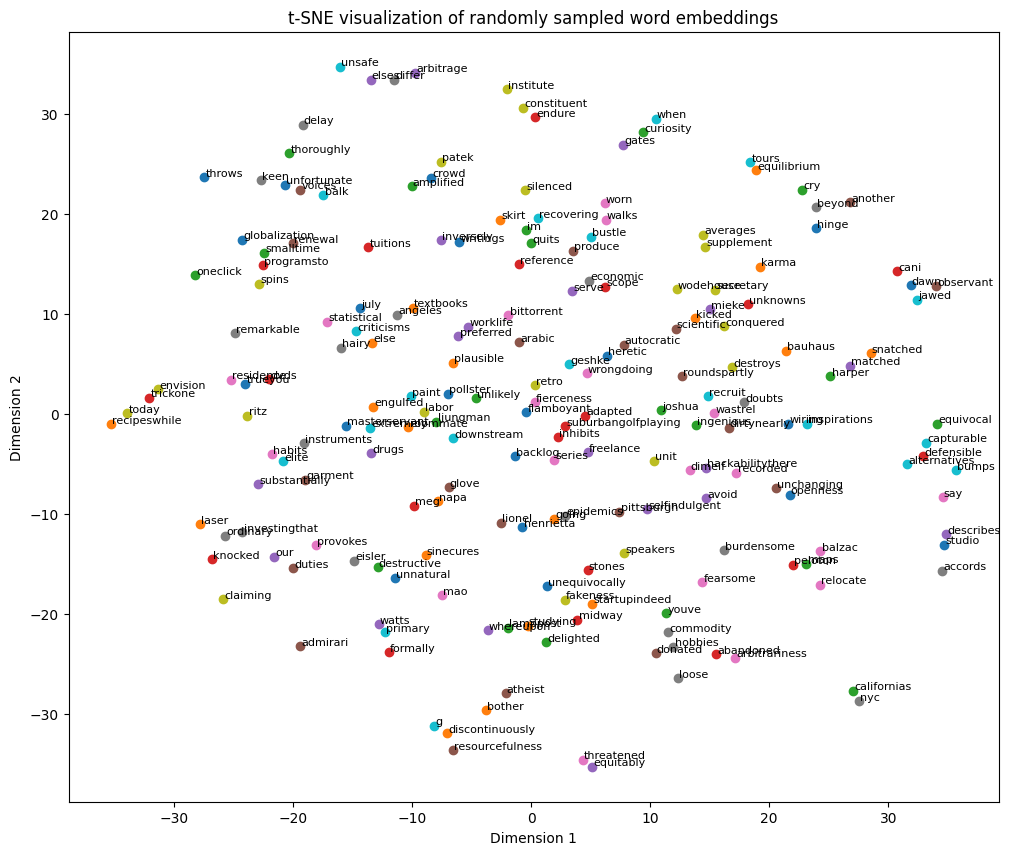

In [ ]:
import random
import numpy as np

# Define how many words you want to sample from the vocabulary
num_words_to_sample = 200  # Adjust based on your preferences and vocabulary size

# Randomly sample words from the vocabulary without defining clusters
all_words = list(vocab.keys())
selected_words = random.sample(all_words, min(num_words_to_sample, len(all_words)))

# Get indices for the sampled words
word_indices = [vocab[word] for word in selected_words]

# Extract the embeddings for the selected words
with torch.no_grad():
    word_embeddings = model.embedding(torch.tensor(word_indices, dtype=torch.long, device=device)).cpu().numpy()

# Use t-SNE to reduce embeddings to 2D space
tsne = TSNE(n_components=2, random_state=0, perplexity=5)
word_embeddings_2d = tsne.fit_transform(word_embeddings)

# Plot the embeddings
plt.figure(figsize=(12, 10))
for i, word in enumerate(selected_words):
    plt.scatter(word_embeddings_2d[i, 0], word_embeddings_2d[i, 1])
    plt.text(word_embeddings_2d[i, 0] + 0.1, word_embeddings_2d[i, 1] + 0.1, word, fontsize=8)

plt.title("t-SNE visualization of randomly sampled word embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()
